In [1]:
!git clone https://github.com/ketul93/lstm-sentence-generator.git ; rm -rf weights/ ;mkdir weights ;cd lstm-sentence-generator/ ; git pull origin

fatal: destination path 'lstm-sentence-generator' already exists and is not an empty directory.
remote: Counting objects: 5, done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/ketul93/lstm-sentence-generator
   bf9e63f..4ade432  master     -> origin/master
Updating bf9e63f..4ade432
Fast-forward
 src/scripts/sample_data_ubuntu.txt | 1025 +++++++++++++++++++++++++++++++++++-
 1 file changed, 1024 insertions(+), 1 deletion(-)


In [2]:
import re
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import math
import random
import sys
import os
import matplotlib.pyplot as plt
from keras.utils import plot_model

Using TensorFlow backend.


**Load File and Build Vocabulary**

In [3]:
data_path = "lstm-sentence-generator/src/scripts/sample_data_ubuntu.txt"
raw_text = open(data_path).read().lower()

# generate list of unique characters, but only include words and some punctuation marks
pattern = re.compile('[a-z]+|\!|\n|\.|,|;')
all_words = re.findall(pattern, raw_text)

unique_words = sorted(set(all_words))

word_to_int = dict((c, i) for i, c in enumerate(unique_words))

# print(unique_words)
# print(word_to_int)

# Generating vocabulary
# later used to make outputs more readable by converting ints back to characters
int_to_word = dict((i, c) for i, c in enumerate(unique_words))

total_num_words = len(all_words)
len_vocab = len(unique_words)

print("Total number of words:\t" + str(total_num_words))
print("Length of vocabulary:\t" + str(len_vocab))

Total number of words:	37773
Length of vocabulary:	3544


**Create Training Data from Text File**

In [4]:
sequence_length = 15 # max number of words to consider at a time.
# this means that each trainig set (training pattern) will be comprised of 20 time steps
step_window = 3

# set up x and y
# convert the words into integers
x_data = [] # list of lists
y_data = []

for i in range(0, total_num_words - sequence_length, step_window):
    
    # extract the first n words (length sequence_length): our "x"
    sequence_in = all_words[i : i+sequence_length]
    
    # extract last word for this window: our "y" (target)
    word_out = all_words[i+sequence_length]
    
    # print('\nx: ' + str(sequence_in) + '\n' + 'y: ' + word_out)
    # print()
        
    # store corresponding integer for each character in the input sequence
    x_data.append(sequence_in)
    y_data.append(word_out)

num_train_patters = len(x_data)
print('Total patterns:\t' + str(num_train_patters))

Total patterns:	12586


**Preparing Training and Testing Data**

In [0]:
x = np.zeros((num_train_patters, sequence_length, len_vocab))
y = np.zeros((num_train_patters, len_vocab))

# Generating one-hot vectors
for i, sentence in enumerate(x_data):
    for t, word in enumerate(sentence):
        x[i, t, word_to_int[word]] = 1
    y[i, word_to_int[y_data[i]]] = 1

**Defining Model**

In [6]:
learning_rate = 0.01
optimizer = RMSprop(lr=learning_rate)
num_memory_units = 256
_dropout = 0.2
model = Sequential()

# model.add(LSTM(num_memory_units, return_sequences=True, input_shape=(sequence_length, len_vocab)))
model.add(LSTM(num_memory_units, input_shape=(sequence_length, len_vocab)))
model.add(Dropout(_dropout))
# model.add(LSTM(num_memory_units))
# model.add(Dropout(0.2))
model.add(Dense(len_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print("Successfully Compiled Model")

Successfully Compiled Model


**Training the Model**

In [7]:
#Number of epochs
num_iterations = 50
batch_size = 128
words_to_generate = 50

prev_loss = math.inf
loss_history = []
accuracy_history = []

val_loss_history = []
val_accuracy_history = []

weights_dir = 'weights/'

if not os.path.exists(weights_dir):
  os.makedirs(weights_dir)

# train the model, output generated text after each iteration
for i in range(num_iterations):
    
    print('\n' + '-'*10 + ' epoch ' + str(i+1) + '/' + str(num_iterations) + ' ' + '-'*10)
        
    history = model.fit(x, y, batch_size=batch_size, epochs=1)
    
    curr_loss = history.history['loss'][0]
    loss_history.append(curr_loss)
    
    # save weights if loss improves
    if (curr_loss < prev_loss):
        print("Loss improved from " + str(prev_loss) + " to " + str(curr_loss) + ". Saving weights.")
        #Saving model in hdf5(Hierarchical Data Format) file
        #model.save_weights(weights_dir + 'weights_epoch-{}_loss-{}.hdf5'.format(i, curr_loss))
        model.save_weights(weights_dir + 'weights_min.hdf5'.format(i, curr_loss))
        prev_loss = curr_loss
    
    #Randomly intialize the index from the whole corpus
    start_index = random.randint(0, total_num_words - sequence_length - 1)
    seed_sentence = all_words[start_index : start_index + sequence_length]

    print('\n-> seed: "' + ' '.join(seed_sentence) + '" ...\n')

    generated_sentece =[]
    
    for i in range(words_to_generate):
        
        x_input = np.zeros((1, sequence_length, len_vocab))
        for t, word in enumerate(seed_sentence):
            x_input[0, t, word_to_int[word]] = 1.

        predictions = model.predict(x_input, verbose=0)[0]
        
        if i == num_iterations-1:
            final_predicted = predictions
        
        # Fetching the highest probable words
        predicted_word_index = np.argmax(predictions) 
        predicted_word = int_to_word[predicted_word_index]

        seed_sentence = seed_sentence[1:] + list([predicted_word])

        if re.match('[a-z]', predicted_word):
            generated_sentece.append(" " + predicted_word)
        else:
            generated_sentece.append(predicted_word)
        
    #print(generated_sentece)
    print (''.join(word for word in generated_sentece))


---------- epoch 1/50 ----------
Epoch 1/1
12586/12586 [==============================] - 11s 904us/step - loss: 6.3215
Loss improved from inf to 6.3214674719600294. Saving weights.

-> seed: "me on how can i repair my grub 
 amphi , actually i am 
" ...


,,

,,

,,

,,

,,

,,

,,

,,

,,

,,

,,

,,

,

---------- epoch 2/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 777us/step - loss: 5.5343
Loss improved from 6.3214674719600294 to 5.534329132341949. Saving weights.

-> seed: "read this at the end 
 ok thank you 
 amphi , dual booting or" ...


 i can t know a way to the the server.... com com com com com com com com okee automatrix vert vert grief okee okee grief grief hahahah ok
 i can t need to the to the to the.... com

---------- epoch 3/50 ----------
Epoch 1/1
 5632/12586 [============>.................] - ETA: 5s - loss: 4.9882

12586/12586 [==============================] - 10s 777us/step - loss: 4.9798
Loss improved from 5.534329132341949 to 4.979834245002537. Saving weights.

-> seed: ". 
 in the expert install you can set it up to have a root" ...

..................................................

---------- epoch 4/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 777us/step - loss: 4.4930
Loss improved from 4.979834245002537 to 4.492977640084388. Saving weights.

-> seed: "you ve got a third drive , maybe raid 
 alwaysicey , what i m" ...

 install
 what is the same problem
 i can t get it to use the same problem
 i can t get it to my the server
 i can t a a cd
 i have to a way to do it
 it, i can t

---------- epoch 5/50 ----------
Epoch 1/1
 7552/12586 [=================>............] - ETA: 3s - loss: 3.9220

12586/12586 [==============================] - 10s 778us/step - loss: 3.9580
Loss improved from 4.492977640084388 to 3.958039065868245. Saving weights.

-> seed: "stereo 
 i m looking for help with agpgart and a radeon 
 terry ," ...


 what s
 i can t be the of in the same and then, but it
 is there a way to do that
 i can t use the kernel, and and then, and then, and then, and then, it s


---------- epoch 6/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 779us/step - loss: 3.3399
Loss improved from 3.958039065868245 to 3.3398974166089963. Saving weights.

-> seed: "amule but i want to uninstall it , how can i know what is the" ...

 name.
 can you get a kernel
 what the ubuntu

 you can use help me with the ubuntu
!

 i don t
 i have a problem...
 i get not
 i m not
 ok
 i m

---------- epoch 7/50 ----------
Epoch 1/1
 5248/12586 [===========>..................] - ETA: 5s - loss: 2.5300

12586/12586 [==============================] - 10s 781us/step - loss: 2.7475
Loss improved from 3.3398974166089963 to 2.7475318663945814. Saving weights.

-> seed: "formatting it clean 
 sivik i currently have ubuntu installed an no spare partitions ," ...

 but not be be for for a server in an server work
 i am not sure what you can someone me the ubuntu.
 what is the way to do this
 i have no problem. i have a server...
 so i just

---------- epoch 8/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 783us/step - loss: 2.2050
Loss improved from 2.7475318663945814 to 2.2049525128095873. Saving weights.

-> seed: ", but you might need more than that is that one of those shared memory" ...

 use a bit of of to sivik, i ve so it s!
! tell t about a can i know a new install, i had to use it...
 i have a server with with my am on for for for.


---------- epoch 9/50 ----------
Epoch 1/1
 3968/12586 [========>.....................] - ETA: 6s - loss: 1.4876

12586/12586 [==============================] - 10s 781us/step - loss: 1.7382
Loss improved from 2.2049525128095873 to 1.7381698581347609. Saving weights.

-> seed: "is your swap partition , iirc from your fdisk l output what is the kernel" ...

 command t
 grub is the command line
 ok, but i think a little question, how can i do it
 you installed on the the command line you should be at all the command line you should be at for the command if you guys


---------- epoch 10/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 778us/step - loss: 1.4039
Loss improved from 1.7381698581347609 to 1.4038560294241174. Saving weights.

-> seed: "up with nautilus . i remember i used to be able to do such a" ...

 or an hd, just cant cant now i get it would use for best;
 no pastebin a dli, what should i do that
 i have no server
 yes
 yes
 yes, so s only get install now
 no no there there

---------- epoch 11/50 ----------
Epoch 1/1
 3712/12586 [=======>....................

12586/12586 [==============================] - 10s 777us/step - loss: 1.1264
Loss improved from 1.4038560294241174 to 1.1264053344461358. Saving weights.

-> seed: "the right repo needed to install mplayer 
 tried running the command on both 
" ...

 dli, what should i do next
 hymntolife, install any ubuntu ubuntu.....
 so i can i install it
 so it is now known as helldragon
 i didnt it a root in the ubuntu partition
 tagabasak, sorry, i

---------- epoch 12/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 779us/step - loss: 0.9513
Loss improved from 1.1264053344461358 to 0.9513139186082764. Saving weights.

-> seed: "sivik , when i try to remount it it says no entry in fstab ," ...

 because you it it in the ubuntu server
 i mean so that s;

 you can t a vnc in work
 then use how can i know the x from a....
; i know my ubuntu
 i installed..

---------- epoch 13/50 ----------
Epoch 1/1
 3968/12586 [========>.....................] - ETA: 6s - loss: 0.5493

12586/12586 [==============================] - 10s 778us/step - loss: 0.8300
Loss improved from 0.9513139186082764 to 0.8299943528170808. Saving weights.

-> seed: "i should be on grub prompt 
 lemme see 
 ubotu , sudo dpkg i" ...

 package... did that i ubuntu it up the
 i can i ve vnc
 dli, what i do i mean
 what is the disk info
 again
 ok ok
 i can t
 you can use
 ok
 how can i

---------- epoch 14/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 779us/step - loss: 0.7283
Loss improved from 0.8299943528170808 to 0.7283145677545161. Saving weights.

-> seed: "isn t enough information in the stuff you ve pasted above to diagnose your problem" ...


..
 yes, but that s no im.
 no problem
 hymntolife, ok. that.... i dont know i can get a new
 sivik, yes
 i do you with windows didn t i have.
 yes

---------- epoch 15/50 ----------
Epoch 1/1
 4736/12586 [==========>...................] - ETA: 6s - loss: 0.4379

12586/12586 [==============================] - 10s 777us/step - loss: 0.6588
Loss improved from 0.7283145677545161 to 0.6588314532210712. Saving weights.

-> seed: "sda 
 it s great , it ll really simplify any of that stuff if" ...

 i have your new user it on it same not have you can sudo fdisk it dev hda and it can i can get it when you run and it it it
 you you need to open the new user ubuntu lol i installed when i run and it

---------- epoch 16/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 777us/step - loss: 0.6136
Loss improved from 0.6588314532210712 to 0.6136032295079294. Saving weights.

-> seed: ", i ll just take a peak 
 i think 
 yep . that s" ...

 help with some name
 i can t get anything of a name... does that s if you want to get a way to do something
 but with is there way to do this
 amphi, i do that
 you ve still a right

---------- epoch 17/50 ----------
Epoch 1/1
 4352/12586 [=========>....................] - ETA: 6s - loss: 0.3434

12586/12586 [==============================] - 10s 776us/step - loss: 0.5842
Loss improved from 0.6136032295079294 to 0.5841559080181186. Saving weights.

-> seed: "as sub off 
 i get into a blue screen 
 with options 
 for" ...

 selecting selecting tagabasak, tagabasak, read grub, grub is the now error!
 http paste. ubuntu nl. org
 should i m kernel not this, and then run the kernel says to and the server to do it is dapper so after is there

---------- epoch 18/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 776us/step - loss: 0.5478
Loss improved from 0.5841559080181186 to 0.5478337316469113. Saving weights.

-> seed: "using l label or by uuid , using u uuid . 
 nffrsvw o options" ...

 p


 what is when i any helldragon
 there you can i get my ubuntu that

 you perhaps more
 yes is what s you mean what s is the way
 dli, what should do do you mean what what is the cd

---------- epoch 19/50 ----------
Epoch 1/1
 3840/12586 [========>.....................

12586/12586 [==============================] - 10s 781us/step - loss: 0.5300
Loss improved from 0.5478337316469113 to 0.5300141778674959. Saving weights.

-> seed: "hel that , methinks . . . 
 i hitted e , hitted e another" ...

 then then it and type, and is things a need to to with that
 no such i or directory
 i tried not
 what is are what
 but do
 how can i know the how do i there a no like is there there


---------- epoch 20/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 780us/step - loss: 0.5114
Loss improved from 0.5300141778674959 to 0.5113816865767656. Saving weights.

-> seed: "to my ubuntu thunderbird 
 dli , do i have to make direcory proc on" ...

 on
 hda
!
!
!
!
! wine!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

---------- epoch 21/50 ----------
Epoch 1/1
 4608/12586 [=========>....................] - ETA: 6s - loss: 0.3230

12586/12586 [==============================] - 10s 781us/step - loss: 0.5228

-> seed: "windows 
 metalhedd , shit man i guess i will come back some other time" ...

, get get to there
 no, there is no mplayer
 what s
 the problem... oh for it to one that the the is in the server is you mean
 what s
 hmm is... does so it it is

---------- epoch 22/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 781us/step - loss: 0.4997
Loss improved from 0.5113816865767656 to 0.4997012682830929. Saving weights.

-> seed: "fwiw , but it was alt ctrl some meta key fn 
 thanks 
 okay" ...

, run with use
 you know what s get install there
 no the dli, i should be a little slow, there graphics can a installed the get install to my ubuntu, and it on the livecd to have am but not really how can i

---------- epoch 23/50 ----------
Epoch 1/1
 6144/12586 [=============>................] - ETA: 4s - loss: 0.3127

12586/12586 [==============================] - 10s 780us/step - loss: 0.4931
Loss improved from 0.4997012682830929 to 0.4931246552390816. Saving weights.

-> seed: "or used a laptop with ubuntu . 
 which fs do you use 
 
" ...

 didn, my use is there any
 i dont my the server is to hda
 cd,
 know as that i
 no use
 what i just just the new but i have to have to do that.. have to do that
 managu

---------- epoch 24/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 780us/step - loss: 0.4773
Loss improved from 0.4931246552390816 to 0.47728081172322995. Saving weights.

-> seed: "
 got 
 nelisa , how can i fix this 
 capitalization error 
 sudo" ...

 you get my and i
 see it s yes
 i just installed it and i can t really it to work
 ubuntu dapper i if i have to edit the screen
 no...... so i have no back the time time

---------- epoch 25/50 ----------
Epoch 1/1
 4864/12586 [==========>...................] - ETA: 5s - loss: 0.2796

12586/12586 [==============================] - 10s 778us/step - loss: 0.4933

-> seed: "human beings . . 
 its for animal beings 
 darwin try saying yes 
" ...

 grub grub
 now is just just installed
 and it run it says that it
 because need to the files with that
 the an error that run this doesn
 amphi, any linux to on that that s no fault
 ok
 how m i

---------- epoch 26/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 778us/step - loss: 0.4640
Loss improved from 0.47728081172322995 to 0.4640009810506644. Saving weights.

-> seed: "bought , yesterday , was a dud . . so i took it back today" ...

 you forgot
 one at had the problem with. i. the know i m not
 yes
 but this is what
 i tried
 what trying to work

 anyone, but i run is wait it
 yes
 if that s the not

---------- epoch 27/50 ----------
Epoch 1/1
 5632/12586 [============>.................] - ETA: 5s - loss: 0.2703

12586/12586 [==============================] - 10s 775us/step - loss: 0.4722

-> seed: "of firefox . from source 
 how can i know what ports i have open" ...


! i
 ubuntu user and windows...
 am
 doing here as
 the me, the file there there a to to the game with with
 i ve linux newbie some webmin
 dli has at about that
 the do you have

---------- epoch 28/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 778us/step - loss: 0.4586
Loss improved from 0.4640009810506644 to 0.4586456458670487. Saving weights.

-> seed: "
 yeah 
 it looks fine to me 
 okay , done . 
 sudo" ...

 i ubuntu. for a wiki of!
 darwin, the not not that a be in to have an option to that to old, so so did i m not or how they i set t up i or would when i type it was it


---------- epoch 29/50 ----------
Epoch 1/1
 6016/12586 [=============>................] - ETA: 5s - loss: 0.2669

12586/12586 [==============================] - 10s 779us/step - loss: 0.4484
Loss improved from 0.4586456458670487 to 0.44843715799644757. Saving weights.

-> seed: "fstab 
 how do i run it once it s installed 
 mount device at" ...

 if you gnome run in or in dont to know what in the name
 the package that make it okay.
 you want to i have a just question what, you you be an. or something an, and there the no such. or there

---------- epoch 30/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 784us/step - loss: 0.4339
Loss improved from 0.44843715799644757 to 0.43391553350307976. Saving weights.

-> seed: "
 well , brute forcing my password is impossible . 
 k wait a second" ...

 sorry sorry
 i, there is it in my server it is is the make the server is
 the, is i dont have i do it
 yes, get the the is on the server with a program newbie
 what, the disk that


---------- epoch 31/50 ----------
Epoch 1/1
 3968/12586 [========>.....................] - ETA: 6s - 

12586/12586 [==============================] - 10s 782us/step - loss: 0.4245
Loss improved from 0.43391553350307976 to 0.4245129962064457. Saving weights.

-> seed: "enable universe and multiverse 
 yes 
 can i use any of those 
 !" ...

 you
 an know your,. you know there of the way to linux this
 tagabasak, after that
 probably, webmin it
 yes, what is the command line... if i was using the x driver is it this
 and ubuntu

---------- epoch 32/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 781us/step - loss: 0.4391

-> seed: "want into a jpg 
 nop . . . just that file 
 lemme see" ...

. is, etc, but i dont still i dont, i ve the my it i just was for
 you do
 it s something, but the see what it is there
 no, there is is there apt way to get it or my

---------- epoch 33/50 ----------
Epoch 1/1
 4480/12586 [=========>....................] - ETA: 6s - loss: 0.2427

12586/12586 [==============================] - 10s 779us/step - loss: 0.4375

-> seed: "and tell people the url 
 how s that 
 hmm i don t know" ...

 one one of dont
 sivik, yes
 it is is now
 can i ubuntu any the how to do it.. i m not
 sure what what the do i mean to root is have to use the wine
! preface!!!

---------- epoch 34/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 780us/step - loss: 0.4450

-> seed: "video 
 the ubuntu installer will overwrite the boot record with a boot loader ," ...

 present present and and and and then the the same one
 the ve will but not i installed
 any,
 how see i. the s trio is the server is
 any not t my cd
 i there are a a installed
 i do

---------- epoch 35/50 ----------
Epoch 1/1
 6784/12586 [===============>..............] - ETA: 4s - loss: 0.2977

12586/12586 [==============================] - 10s 777us/step - loss: 0.4555

-> seed: "like , totally , https wiki . ubuntu . com sshhowto or https wiki ." ...

 ubuntu. com there
 way to
 or some resolution there is.
 you dont try a
 of is, but i just the root it but. did you get if there user, and i dont t the root
 oh
 ok
 darwin

---------- epoch 36/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 784us/step - loss: 0.4424

-> seed: "integration stuff may not work those des must be for something ; , but the" ...

 root profs to


 didnt can the managu in grub what with install do
 linux problem look work
 grub does i install it
 yes is not the it.
 dli, done

 i
 tried
 what s that do
 old

---------- epoch 37/50 ----------
Epoch 1/1
 5888/12586 [=============>................] - ETA: 5s - loss: 0.2636

12586/12586 [==============================] - 10s 782us/step - loss: 0.4603

-> seed: "! limewire 
 first you need ! java , then download the http www ." ...

 ubuntu. org and i the trying to files it in the, i am
 i need to some with with not nvidia i it trying to before
 for have
 to same that for the same and, my ubuntu.
!
!
 please

---------- epoch 38/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 778us/step - loss: 0.4590

-> seed: "iso image and burning it simultaneously . things might work better if you did those" ...

 those, humm is it
 i need to do with windows that if i is the root with a
 do that
 about some is the about the. this is is any way to do that
 nv, then my it but be at for this

---------- epoch 39/50 ----------
Epoch 1/1
 6272/12586 [=============>................] - ETA: 4s - loss: 0.2908

12586/12586 [==============================] - 10s 775us/step - loss: 0.4715

-> seed: "no lo puedo installar . . . . 
 ! glibc 
 i haven t" ...

 a a problem
 in the here, i do
 tell, the error

 you have to use the wine for the ubuntu but in the same password in
 but but sure with the command line. i need to i m not to the files

---------- epoch 40/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 779us/step - loss: 0.4811

-> seed: "i pod , do i extract them from database 
 theres a winechat right 
" ...

 dli, what i do i have to with to
 me
 i use the to and
 but sure
 what s what
 of

 what,
 you how to get the other a, say
 mount windows
 on p
 i s

---------- epoch 41/50 ----------
Epoch 1/1
 6784/12586 [===============>..............] - ETA: 4s - loss: 0.3000

12586/12586 [==============================] - 10s 776us/step - loss: 0.4513

-> seed: "cdrom it should be bootable 
 khoacalacan , http www . ubuntuforums . org showthread" ...

. php t read couldn wasn the same driver
 this problem,...
 for what dapper of root
 i could the on you gb,, can you get me in the can run open it in in terminal
 my, sudo on apt

---------- epoch 42/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 778us/step - loss: 0.4524

-> seed: "to gui . . becaus of the alerts . im on a shell now ." ...


 p
 i know what to do

 what
 is do
.
 there, if you is your root partition
 i do you have and, then and should
 should anyone
 no, there is segfaulting way
 i dont to do

---------- epoch 43/50 ----------
Epoch 1/1
 6912/12586 [===============>..............] - ETA: 4s - loss: 0.2899

12586/12586 [==============================] - 10s 777us/step - loss: 0.4487

-> seed: "down to the server just to fix that 
 maximum size you mean i don" ...

 t know to google is to an
 it s in the ubuntu any

 how would i fix them
 you, it s in
 you have to other them ubuntu. a..............

---------- epoch 44/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 776us/step - loss: 0.4441

-> seed: ". ew clan . co . uk tuts images webtut . jpg 
 thats how" ...

 it do
 i just into a and
 my my is
 darwin, you get the there is is there way to get it to can that
 you can
 fdisk it you be what is the command and
 all
 my ubuntu is there for

---------- epoch 45/50 ----------
Epoch 1/1
 7680/12586 [=================>............] - ETA: 3s - loss: 0.3323

12586/12586 [==============================] - 10s 783us/step - loss: 0.4641

-> seed: "wrong 
 rug , i almost missed that . 
 that is the way to" ...

 do something
 perhaps, i m not, you, but i would there your a way to do something
 but, i have to install it, and i run run from it s this
 is,, and.
 now, what is the

---------- epoch 46/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 780us/step - loss: 0.4679

-> seed: "to this 
 ok thanks man 
 amphi , it s in home cs warservers" ...

.. no no, i can use get my my
.
 can, get my ubuntu is!
!,
 http www. gnomefiles. org app. php soft id
 foo, didn, and s what it is is the way one

---------- epoch 47/50 ----------
Epoch 1/1
 7808/12586 [=================>............] - ETA: 3s - loss: 0.3504

12586/12586 [==============================] - 10s 780us/step - loss: 0.4614

-> seed: "open or how do u install programs 
 blanky is now known as blank 
" ...

 you have have have same working with the got but but driver with says not the the; i dli ok
..
 can t help me for the
 you have use use yes to do
 but so think what is the got on driver


---------- epoch 48/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 779us/step - loss: 0.4798

-> seed: "ubuntu laptop 
 i ve got ubuntu running at x on an acer with an" ...


 card do
 it s in a.
 you i am
 darwin, you are the kernel and
 it,
 what it
 you on what
 dli, what
 do do
 tell about about that you can i can me it in

---------- epoch 49/50 ----------
Epoch 1/1
 6784/12586 [===============>..............] - ETA: 4s - loss: 0.3187

12586/12586 [==============================] - 10s 775us/step - loss: 0.4680

-> seed: "you built yourself 
 no 
 from what i hear , webmin is not for" ...

 a;
! is there a
 to, it here. i have a sound question even that to it be, but you can t get it to can ubuntu
 i installed
 but... a s install it
 yes, darwin the

---------- epoch 50/50 ----------
Epoch 1/1
12586/12586 [==============================] - 10s 776us/step - loss: 0.4826

-> seed: "mas ayuda . 
 
 well i find it very disorganized and confusing for newcomers" ...

 it
 know is there way to do the
 ghost, the have to driver is as
 dli, i can me, how do i run the deb in i
 how, i run the deb
 im,
 i, t
 no such


In [8]:
!cd weights/ ; ls

weights_min.hdf5


In [9]:
loss = model.evaluate(x, y, batch_size=batch_size, verbose=1)
print("loss: ", loss)

12586/12586 [==============================] - 7s 528us/step
loss:  0.18726590942090027


loss history:
[6.3214674719600294, 5.534329132341949, 4.979834245002537, 4.492977640084388, 3.958039065868245, 3.3398974166089963, 2.7475318663945814, 2.2049525128095873, 1.7381698581347609, 1.4038560294241174, 1.1264053344461358, 0.9513139186082764, 0.8299943528170808, 0.7283145677545161, 0.6588314532210712, 0.6136032295079294, 0.5841559080181186, 0.5478337316469113, 0.5300141778674959, 0.5113816865767656, 0.5228472643657801, 0.4997012682830929, 0.4931246552390816, 0.47728081172322995, 0.4933272648005423, 0.4640009810506644, 0.4721809186902085, 0.4586456458670487, 0.44843715799644757, 0.43391553350307976, 0.4245129962064457, 0.43912618339828935, 0.4375117103852321, 0.44497865997284447, 0.4554619791112567, 0.4423802796388381, 0.4603281440756459, 0.45900044083386904, 0.4714524402122855, 0.48114157434338023, 0.4513406906032456, 0.4524267707609058, 0.44867721792436566, 0.4440940445942851, 0.46410736364418875, 0.4679099219309096, 0.4613881425506717, 0.47979152712177137, 0.46796344699663367

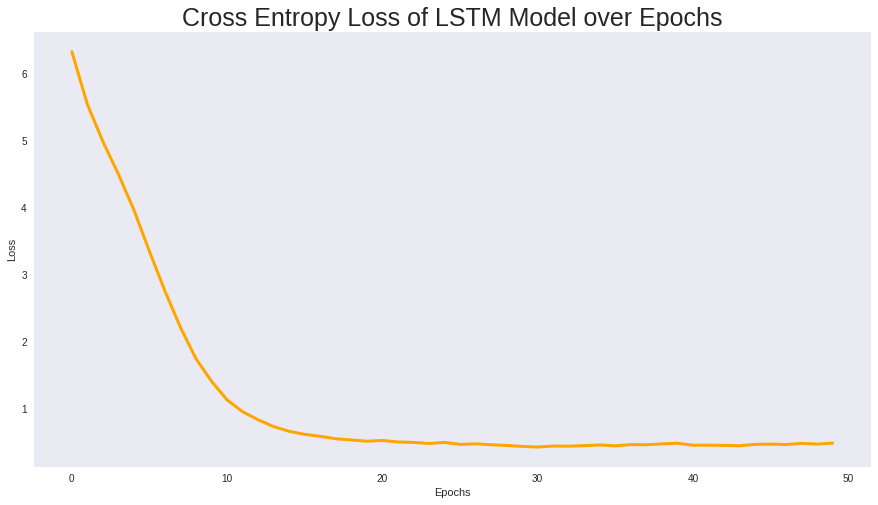

In [10]:
print('loss history:')
print(loss_history)

plt.figure(figsize=(15,8))
plt.rc('font', size=20)
plt.plot(loss_history, lw=3, c='orange')
plt.title('Cross Entropy Loss of LSTM Model over Epochs', fontsize=25)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig("loss.png")
plt.grid()
plt.show()

In [11]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               3892224   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3544)              910808    
_________________________________________________________________
activation_1 (Activation)    (None, 3544)              0         
Total params: 4,803,032
Trainable params: 4,803,032
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#capturing the lowest loss weights
!ls weights/


weights_min.hdf5



# **Prediction on trained Models' weights**

---



Prediction Model definition

In [0]:
sequence_length = 15

learning_rate = 0.01
optimizer = RMSprop(lr=learning_rate)
#Number of memory nodes in LSTM model
num_memory_units = 256

model = Sequential()

model.add(LSTM(num_memory_units, input_shape=(sequence_length, len_vocab)))
model.add(Dropout(0.2))
model.add(Dense(len_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Predicttion

In [0]:
def add_temperature(predictions, temperature=1.0):

    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions) / temperature
    exp_predictions = np.exp(predictions)
    predictions = exp_predictions / np.sum(exp_predictions)
    
    probabilities = np.random.multinomial(1, predictions, 1)
    return np.argmax(probabilities)

In [0]:
def get_random_word(n=1, array=unique_words):

    random_words = []
    
    random_indices = random.sample(range(0, len(array)), n)
    
    # in-place shuffle
    random.shuffle(array)

    # take the first n elements of the now randomized array
    return array[:n]

In [0]:
# load weights of compiled LSTM model
weights_path = 'weights/weights_min.hdf5'
model.load_weights(weights_path)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Handling User Inout

In [0]:
random_seed = False

Selection of seed based on user input (if available) or Random

In [0]:
def generate_seed(user_input):
  #user_input = "is there a way to lower my screen resolution, Ubuntu loaded tops and is hard on my eyes"
  words_to_generate = 15
  seed_sentence = ["\n"] * sequence_length

  if not random_seed:

      pattern = re.compile('[a-z]+|\!|\n|\.|,|;')
      user_input_edit = user_input.lower()
      user_input_edit = re.findall(pattern, user_input)

      if (len(user_input_edit) > sequence_length):
          # need to truncate

          seed_sentence = user_input_edit[:sequence_length]

      elif (len(user_input_edit) < sequence_length):
          # need to pad

          # get number of elements missing in user input
          missing_elems = sequence_length - len(user_input_edit)

          seed_sentence[0:missing_elems+1] = get_random_word(missing_elems)
          seed_sentence[-(len(user_input_edit)):] = user_input_edit

      # check all words provided are in the vocabulary
      for i, word in enumerate(seed_sentence):
          # if it doesnt exist, replace it with one that does
          if word not in word_to_int.keys():
              seed_sentence[i] = get_random_word()[0]

      #print('-> seed: "' + user_input + '" ...\n')

  else:
      #if no seed was not supplied
      # pick a random seed
      random_index_start = np.random.randint(0, total_num_words - sequence_length - 1)
      seed_sentence = all_words[random_index_start : random_index_start + sequence_length]
  
  return seed_sentence
      #print('-> seed: "' + ' '.join(seed_sentence) + '" ...')

In [0]:
def generate_sentence(user_input,u_number):
  generated_sentece =[]
  seed_sentence = generate_seed(user_input)
  for i in range(words_to_generate):

      x_input = np.zeros((1, sequence_length, len_vocab))
      for t, word in enumerate(seed_sentence):
          x_input[0, t, word_to_int[word]] = 1.

      predictions = model.predict(x_input, verbose=0)[0]
      predicted_word_index = add_temperature(predictions, 0.5)
      predicted_word = int_to_word[predicted_word_index]

      seed_sentence = seed_sentence[1:] + list([predicted_word])
      if re.match('[a-z]', predicted_word):
        generated_sentece.append(" " + predicted_word)
      else:
        generated_sentece.append(predicted_word)
    
  print("User " + str(u_number) + " is saying :")
  print()
  print (''.join(word for word in generated_sentece))
  print()
  return (''.join(word for word in generated_sentece))   
  #print(generated_sentece)

In [0]:
def chatbot(seed_sentence,num_dialogs=2):
  print("User 0 is saying :")
  print()
  print(seed_sentence)
  print()
  while num_dialogs > 0:
    repl = generate_sentence(seed_sentence,(num_dialogs%2))
    num_dialogs -= 1
  print("Thanks for using chatbot designed by Ketul :) ")

In [33]:
#chatbot("Is there a way to lower my screen resolution, Ubuntu loaded tops and is hard on my eyes ?",15)
chatbot("Is Ubuntu better than Windows ? ",2)

User 0 is saying :

Is Ubuntu better than Windows ? 

User 0 is saying :


.. can look http. ubuntu be
. there will use use wine ssh, can help me vnc some resolution for;
 such is so, all grub tell
 of
 installed

 at dual you i i
 on!
 my

User 1 is saying :

 it it did if was that that that that i up
 it
,, need help with server what with is
 way theres
 some something with is commands for dont cd, as. installed then
,, no the or is a..

Thanks for using chatbot designed by Ketul :) 
